<a href="https://colab.research.google.com/github/Natali-bali/TensorFlow_Tutorial/blob/master/04_Transfer_learning_feauture_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning

### Top 4 Pre-Trained Models for Image Classification:


https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/


- ImageNet https://image-net.org/download

This dataset spans 1000 object classes and contains 1,281,167 training images, 50,000 validation images and 100,000 test images
- CIFAR https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset.

- MNIST http://yann.lecun.com/exdb/mnist/ 

handwritten digits


**Pretrained models:**
- tensorflow.keras.applications.MobileNet()
- tensorflow.keras.applications.vgg16.VGG16()
- tensorflow.keras.applications import ResNet50
- tensorflow.keras.applications.inception_v3 import InceptionV3
- import efficientnet.keras as efn (best one so far)


What we're going to cover

- Introduce transfer learning (a way to beat all of our old self-built models)
- Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
- Build a transfer learning feature extraction model using TensorFlow Hub
- Introduce the TensorBoard callback to track model training results
- Compare model results using TensorBoard




In [20]:
!nvidia-smi

Wed Jun 16 09:28:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |   8880MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import preprocessing
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K
import random

### Download and unzip Data

In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

--2021-06-16 12:25:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.110.128, 142.251.5.128, 74.125.206.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.110.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  28.7MB/s    in 5.6s    

2021-06-16 12:25:52 (28.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
zip_ref = zipfile.ZipFile('/content/10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

### Check directories

In [4]:
from os import walk, listdir

In [5]:
for dirpath, dirnames, filenames in walk('/content/10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories, {len(filenames)} files in {dirpath}')

There are 2 directories, 0 files in /content/10_food_classes_10_percent
There are 10 directories, 0 files in /content/10_food_classes_10_percent/train
There are 0 directories, 75 files in /content/10_food_classes_10_percent/train/ice_cream
There are 0 directories, 75 files in /content/10_food_classes_10_percent/train/hamburger
There are 0 directories, 75 files in /content/10_food_classes_10_percent/train/pizza
There are 0 directories, 75 files in /content/10_food_classes_10_percent/train/chicken_wings
There are 0 directories, 75 files in /content/10_food_classes_10_percent/train/sushi
There are 0 directories, 75 files in /content/10_food_classes_10_percent/train/steak
There are 0 directories, 75 files in /content/10_food_classes_10_percent/train/chicken_curry
There are 0 directories, 75 files in /content/10_food_classes_10_percent/train/fried_rice
There are 0 directories, 75 files in /content/10_food_classes_10_percent/train/grilled_salmon
There are 0 directories, 75 files in /content/

### Get Classes Names

In [6]:
import pathlib
data_dir = pathlib.Path('/content/10_food_classes_10_percent/train')
classes_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(classes_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


### Plot random pictures

In [7]:
def plot_pictures(path):
  dir_names = listdir(path)
  print(len(dir_names))
  plt.figure(figsize=(10,10))
  for dir_name, num in zip(dir_names, range(len(dir_names))):
    files_names = listdir(f'{path}/{dir_name}')
    random_img = preprocessing.image.load_img(f'{path}/{dir_name}/{random.choice(files_names)}')
    plt.subplot(3,4,num+1)
    plt.imshow(random_img)
    plt.title(dir_name)
    plt.axis('off')

10


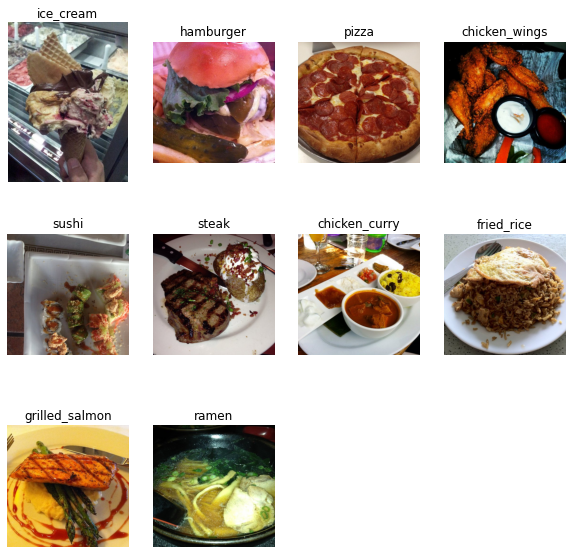

In [8]:
plot_pictures('/content/10_food_classes_10_percent/test')

### Prepare data for loading

In [9]:
train_gen = preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                                   rotation_range = 40,
                                                   width_shift_range = 0.2,
                                                   height_shift_range = 0.2,
                                                   horizontal_flip = True,
                                                   zoom_range = 0.2)
test_gen = preprocessing.image.ImageDataGenerator(rescale = 1/255.)

In [10]:
train_data = train_gen.flow_from_directory(directory = '/content/10_food_classes_10_percent/train',
                                           target_size = (224, 224),
                                           class_mode = 'categorical',
                                           seed = 42)
test_data = test_gen.flow_from_directory('/content/10_food_classes_10_percent/test',
                                         target_size = (224, 224),
                                         seed = 42)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### Callback functions
Most popular callback functions:
- *Experiment tracking with TensorBoard* - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
- *Model checkpointing* - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
- *Early stopping* - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.


####1. TensorFlow Board Callback
(functionized because need to create a new one for each model)

In [11]:
import datetime
def create_tf_board_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorflow_callback = keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving TensorBoard log files to {log_dir}')
  return tensorflow_callback

### Build transferlearning model using Tensorflow Hub
https://www.tensorflow.org/hub

choose model and dataset


https://tfhub.dev


We broused 2 models to compare them

efficientnet/b0/feature-vector

 for our problem


In [12]:
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/1'

In [13]:
import tensorflow_hub as hub

In [14]:
def create_model(url, num_classes = 10, input_shape = (224, 224, 3)):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  feature_extractor_layer = hub.KerasLayer(url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape = input_shape) 
  #Note if i add layer to model directly, it doent accept input_shape, so first need to create layer, then add it to model
  
  model = tf.keras.Sequential([feature_extractor_layer, 
                              Dense(num_classes, 
                                    activation='softmax', 
                                    name='output_layer') 
                              ])

  return model

#### Create Resnet model

In [15]:
tf.random.set_seed(42)
K.clear_session()

In [16]:
resnet_model = create_model(resnet_url, train_data.num_classes)

#Note this model works with shape (224, 224,3), in first place i had shapes (256, 256, 3). So i reshaped images 

In [17]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [18]:
resnet_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [19]:
history_resnet = resnet_model.fit(train_data, 
                 epochs = 5, 
                 callbacks = [create_tf_board_callback('tensorflow_hub', 'resnet')],
                 steps_per_epoch = len(train_data),
                 validation_data = test_data,
                 validation_steps = len(test_data)
                 )

Saving TensorBoard log files to tensorflow_hub/resnet/20210616-122608


Epoch 1/5
24/24 [==============================] - 62s 1s/step - loss: 1.9320 - accuracy: 0.3293 - val_loss: 1.2176 - val_accuracy: 0.6096
Epoch 2/5
24/24 [==============================] - 28s 1s/step - loss: 1.1072 - accuracy: 0.6600 - val_loss: 0.8793 - val_accuracy: 0.7092
Epoch 3/5
24/24 [==============================] - 28s 1s/step - loss: 0.8934 - accuracy: 0.7093 - val_loss: 0.7823 - val_accuracy: 0.7488
Epoch 4/5
24/24 [==============================] - 29s 1s/step - loss: 0.7597 - accuracy: 0.7573 - val_loss: 0.7455 - val_accuracy: 0.7560
Epoch 5/5
24/24 [==============================] - 29s 1s/step - loss: 0.6896 - accuracy: 0.7787 - val_loss: 0.7236 - val_accuracy: 0.7564


In [20]:
def plot_loss_curves(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))

  #Plot Loss
  plt.plot(epochs, train_loss, label = 'Training Loss')
  plt.plot(epochs, val_loss, label = 'Validation Loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()

  #Plot Accuracy
  plt.figure()
  plt.plot(epochs, train_accuracy, label = 'Training Accuracy')
  plt.plot(epochs, val_accuracy, label = 'Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend()

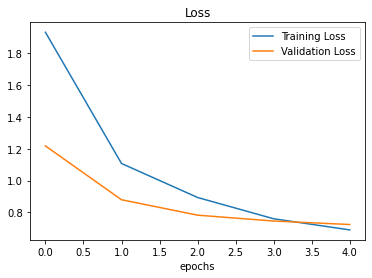

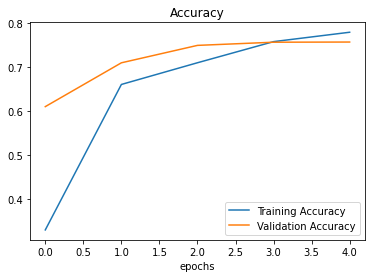

In [21]:
plot_loss_curves(history_resnet)

In [27]:
tf.random.set_seed(42)
K.clear_session()

In [28]:
efficientnet_model = create_model(efficientnet_url)

In [29]:
efficientnet_model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'categorical_crossentropy')

In [30]:
history_efficientnet = efficientnet_model.fit(train_data, epochs = 5, 
                       callbacks = [create_tf_board_callback('tensorflow_hub', 'efficientnet')],
                       validation_data = test_data,
                       steps_per_epoch = len(train_data),
                       validation_steps = len(test_data))

Saving TensorBoard log files to tensorflow_hub/efficientnet/20210616-123018


Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 1.9386 - accuracy: 0.3667 - val_loss: 1.3859 - val_accuracy: 0.6964
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 1.2388 - accuracy: 0.7107 - val_loss: 0.9381 - val_accuracy: 0.8040
Epoch 3/5
24/24 [==============================] - 27s 1s/step - loss: 0.9384 - accuracy: 0.7760 - val_loss: 0.7548 - val_accuracy: 0.8292
Epoch 4/5
24/24 [==============================] - 27s 1s/step - loss: 0.7756 - accuracy: 0.8227 - val_loss: 0.6521 - val_accuracy: 0.8452
Epoch 5/5
24/24 [==============================] - 26s 1s/step - loss: 0.6867 - accuracy: 0.8360 - val_loss: 0.5957 - val_accuracy: 0.8524


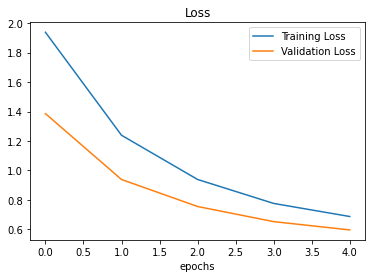

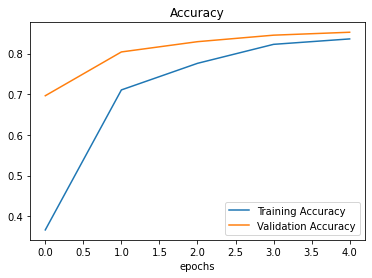

In [31]:
plot_loss_curves(history_efficientnet)